<a href="https://colab.research.google.com/github/r-hugoalves/EDA_com_SQL_e_AWS/blob/master/Explora%C3%A7%C3%A3o_e_an%C3%A1lise_de_dados_de_cr%C3%A9dito_com_SQL_na_AWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploração e análise de dados de crédito com SQL na AWS**

**Nesse estudo, vamos analisar um conjunto de dados que representam informações de clientes de um banco.**

Para o nosso estudo, vamos utilizar as ferramentas S3 e Athena da AWS e uma parte do conjunto de dados disponibilizados [nesse](https://github.com/andre-marcos-perez/ebac-course-utils/tree/main/dataset) repositório*. Além disso, todos os gráficos aqui apresentados foram gerados utilizando o excel.

O conjunto em específico que vamos utilizar pode ser obtido [aqui](https://github.com/r-hugoalves/EDA_com_SQL_e_AWS/blob/master/planilha_geral.csv).

<br>

**.: não vamos trabalhar com todo o conjunto de dados para não ultrapassar o período gratuito da AWS. Por isso, utilizaremos apenas as 2563 primeiras linhas.*

## Dados

Legenda dos dados presentes na tabela:

* idade = idade do cliente
* sexo = sexo do cliente (F ou M)
* dependentes = número de dependentes do cliente
* escolaridade = nível de escolaridade do clientes
* salario_anual = faixa salarial do cliente
* tipo_cartao = tipo de cartao do cliente
* qtd_produtos = quantidade de produtos comprados nos últimos 12 meses
* iteracoes_12m = quantidade de iterações/transacoes nos ultimos 12 meses
* meses_inativo_12m = quantidade de meses que o cliente ficou inativo
* limite_credito = limite de credito do cliente
* valor_transacoes_12m = valor das transações dos ultimos 12 meses
* qtd_transacoes_12m = quantidade de transacoes dos ultimos 12 meses

## Extração dos dados

Os dados obtidos no repositório original contém mais de 10mil linhas. Porém, para não extrapolar o limite dos serviços gratuitos da AWS vamos trabalhar com apenas 2563 linhas. 

Mas temos que tomar alguns cuidados! Quando exportarmos o arquivo seja no formato `xlsx` ou `csv`, existem duas colunas em específico que pode causar erro ao fazermos o upload no S3. 

São as colunas `limite_credito` e `valor_transacoes_12m` do nosso arquivo. Como ambas as colunas tratam de dados do tipo float, devemos substituir a vírgula por ponto antes de subir no S3, caso contrário, ele pode ler a vírgula e separar as informações de forma incorreta quando criarmos a nossa tabela no Athena. Essa substituição foi feita de forma direta e simples no próprio Excel.

Após isso, foi feito o upload no S3 e criação da tabela no Athena, conforme detalhado abaixo.

## Criação da tabela

Após a criação do bucket no S3, foi criada a tabela `credito` no Athena:

``` sql
CREATE EXTERNAL TABLE IF NOT EXISTS default.credito(
   `idade` int,
   `sexo` string,
   `dependentes` int,
   `escolaridade` string,
   `estado_civil` string,
   `salario_anual` string,
   `tipo_cartao` string,
   `qtd_produtos` bigint,
   `iteracoes_12m` int,
   `meses_inativo_12m` int,
   `limite_credito` float,
   `valor_transacoes_12m` float,
   `qtd_transacoes_12m` int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES(
    'serialization.format' = ',',
    'field.delim' = ','
) LOCATION 's3://proj-credito-hra/'
TBLPROPERTIES ('has_encrypted_data'='false');
```

## Exploração dos dados

Nessa fase de exploração dos dados, vamos entender os dados com que estamos trabalhando e também compreender qual o cenário que vamos investigar mais a frente. Afinal, não conseguimos fazer as perguntas de negócio, sem antes conhecer o mínimo dos dados. Só depois disso é que podemos ter os nossos insights e fazer as perguntas adequadas para a análise dos dados.

###**Qual o tamanho do nosso conjunto de dados?**

```sql
SELECT COUNT(*) FROM credito
```

> Resposta: 2563 linhas

###**Qual o perfil dos nossos dados?**


```sql
SELECT * FROM  credito 
LIMIT 10;
```

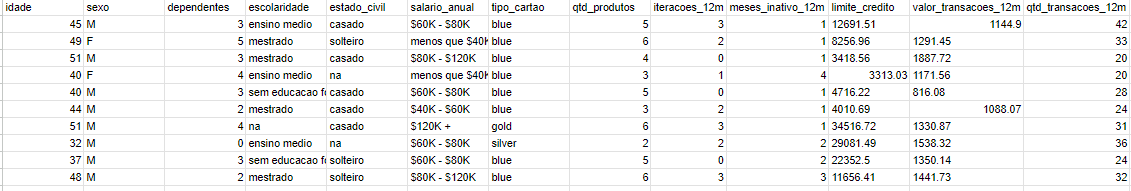

> Numa primeira visualização, temos ideia de que alguns valores são nulos, pois aparecem com "na" em sua descrição.

> Além disso, vemos que algumas das colunas apresentam uma categorização, como a coluna de `escolaridade`, `salario_anual`, `tipo_cartao` e até mesmo `sexo`. Vamos analisar mais de perto essas colunas.

###**Quais são os tipos de categorias que temos em nosso conjunto de dados?**

**Escolaridade**

```sql
SELECT DISTINCT escolaridade FROM credito
```

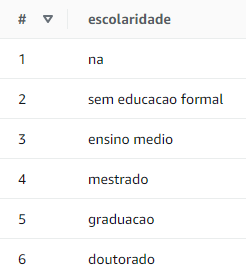

> Podemos observar temos seis tipos de categoria nos nossos dados, e que uma delas em específico contém valores nulos, que na nossa tabela estão descritos como "na"

**Salário anual**

```sql
SELECT DISTINCT salario_anual FROM credito
```

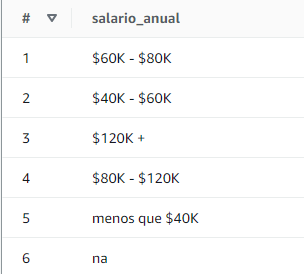

> O salário pelo que observamos não é descrito com o seu valor bruto e específico, mas sim, dentro de uma faixa do salário anual. Mas novamente, encontramos valores nulos "na".

**Tipo do cartão**

```sql
SELECT DISTINCT tipo_cartao FROM credito
```

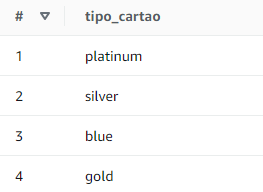

> No tipo de cartão, temos valores bem definidos e dessa vez, nenhum nulo.

**Estado civil**

```sql
SELECT DISTINCT estado_civil FROM credito
```

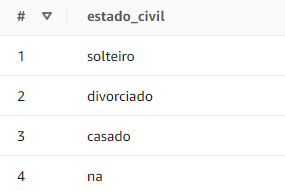

> No estado civil, temos os dados mais comuns, mas também temos uma categoria de valor nulo. O que pode representar outros tipos de estado_civil que não foram coletados.

**Sexo**

```sql
SELECT DISTINCT sexo FROM credito
```

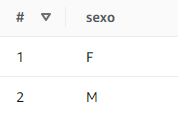

> Na coluna de sexo, temos um valor já esperado, e sem nenhum dado nulo.

## Análise dos dados

Agora que temos conhecimento sobre o nosso conjunto de dados (dataset), podemos enfim fazer algumas perguntas de negócio, a fim de entender melhor os dados e fazer uma análise completa. 

Lembrando que estamos trabalhando apenas com uma parte do conjunto, por isso o resultados das nossas análises aqui feitas representam um passo inicial que pode ser extendido para o conjunto mais completo posteriormente.

É nessa fase de análise de dados que entendemos como está a distribuição dos nosso dados, com medidas de máximo, mínimo, média, desvio padrão, etc. Também tentamos identificar padrões sejam eles explícitos ou não, que nos ajudarão a entender de forma expansiva o restante do conjunto e até mesmo responder algumas perguntas de negócio. Claro, todas essa análise será acompanhada de gráficos, para uma melhor visualização e compreensão dos dados.

Nesse processo de análise, temos que tomar muito cuidado com o que vamos analisar de fato, para não corrermos o risco de ter o resultado final poluído. Ou seja, procuramos evitar o famoso "garbage in, garbage out".

Como nosso projeto, é um caso de estudo, faremos uma análise geral dos nossos dados. Por isso, separamos algumas perguntas que analisaremos com calma no decorrer do projeto. São elas: 

* Quantos clientes eu tenho distribuídos em cada faixa salarial?
* Qual a quantidade de cartões por tipo de cartão?
* Qual a divisão de sexo? 
* Qual a relaçao existente entre o limite de crédito e a escolaridade?
* Qual a relação existente entre o limite de crédito e o salário anual?
* Qual a relação existente entre o limite de crédito e o valor das transações?
* O tipo de cartão está relacionado com o valor das transações e/ou tipo do salário?

###**Quantos clientes eu tenho distribuídos em cada faixa salarial?**

```sql
SELECT COUNT(*) as quantidade,
	salario_anual
FROM credito
GROUP BY salario_anual
ORDER BY quantidade DESC
```

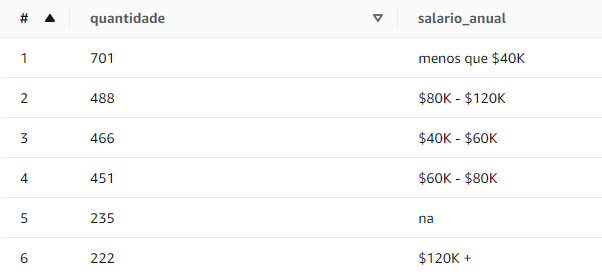

> Nesse conjunto de dados, conseguimos observar que boa parte dos nossos clientes tem uma faixa salarial menor que `40K` e uma pequena parcela possui uma faixa salarial maior que `120K`. Ou seja, caso precise ser feita alguma campanha de publicidade, ou estratégia de venda, elas devem ser feitas em cima do público com faixa salarial menor que `40K` e entre `40K` e `120K` que representa uma boa parte do nosso dataset.

###**Qual a quantidade de cartões por tipo de cartão?***

```sql
SELECT COUNT(*) as quantidade,
	tipo_cartao
FROM credito
GROUP BY tipo_cartao
ORDER BY quantidade DESC
```

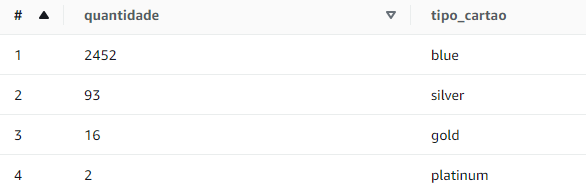

> Observamos que de forma disparada, o tipo de cartão "blue" é o mais comum entre os nossos clientes. E apenas dois possuem o cartão de nível mais alto que é o platinum. Será que existe algum tipo de relação com outras variáveis?

###**Qual a divisão de sexo?**

```sql
SELECT COUNT(*) as quantidade,
	sexo
FROM credito
GROUP BY sexo
ORDER BY quantidade DESC
```

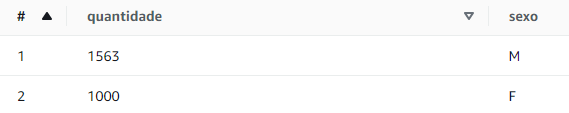

> Podemos observar que, pelo menos nessa parte do conjunto de dados que estamos trabalhando, o número de homens é maior que o número de mulheres. Mas será como será que esse número é distribuído entre os outros dados?

## Conclusão